# Model Evaluation
The following notebook performs measures various metrics involving the models against the provided ground-truth data.
This notebook is meant to be used as a prototype workbench for developing core code for model performance evaluation and comparison.

In our evaluation pipeline, we closely follow the result analysis performed by Gabere et. al.

In [1]:
import math
import numpy as np
import seaborn as sns
import modin.pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:37949 to respond...
Waiting for redis server at 127.0.0.1:19569 to respond...
Starting the Plasma object store with 6.00 GB memory.


In [2]:
# Application Hyperparameters
DATA_ROOT = '../data/out/data3.fasta.txt/'
# SERVERS = ['ADAM_HMM', 'ADAM_SVM', 'AMPA', 'CAMPR3-ANN', 'CAMPR3-DA', 'CAMPR3-RF', 'CAMPR3-SVM']
SERVERS = ['AMPA', 'CMPR3_ANN', 'CMPR3_DA', 'CMPR3_RF', 'CMPR3_SVM', 'DBAASP']
DATASET = ['A', 'D'] # A for AMP3 and D for DAMPD
REVERSE = ['', 'R', 'R1', 'R2', 'R3']

## Load Dataset

In [3]:
data = {}
for s in SERVERS:
    raw = pd.read_csv(DATA_ROOT + s + '.csv')
    data[s] = {}
    for d in DATASET:
        data[s][d] = {}
        for r in REVERSE:
            # Append True Values
            data[s][d][r] = pd.DataFrame(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == False][raw.AMPLabel == 1])
            
            # Filter Out by
            if r == '':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.AMPLabel == 0][raw.PepID.str.contains('R') == False])
            elif r == 'R':
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains('R') == True][raw.PepID.str.contains('R1') == False][raw.PepID.str.contains('R2') == False][raw.PepID.str.contains('R3') == False])
            else:
                data[s][d][r] = data[s][d][r].append(raw[raw.PepID.str.contains(d)][raw.PepID.str.contains(r)])
            
            print(s + ' ['+d+r+']' + ' : ' + str(data[s][d][r].shape[0]) + ' RECORDS')
        print('-'*30)

AMPA [A] : 10278 RECORDS
AMPA [AR] : 3426 RECORDS
AMPA [AR1] : 3426 RECORDS
AMPA [AR2] : 3426 RECORDS
AMPA [AR3] : 3426 RECORDS
------------------------------
AMPA [D] : 3281 RECORDS
AMPA [DR] : 1094 RECORDS
AMPA [DR1] : 1094 RECORDS
AMPA [DR2] : 1094 RECORDS
AMPA [DR3] : 1094 RECORDS
------------------------------
CMPR3_ANN [A] : 10278 RECORDS
CMPR3_ANN [AR] : 3426 RECORDS
CMPR3_ANN [AR1] : 3426 RECORDS
CMPR3_ANN [AR2] : 3426 RECORDS
CMPR3_ANN [AR3] : 3426 RECORDS
------------------------------
CMPR3_ANN [D] : 3281 RECORDS
CMPR3_ANN [DR] : 1094 RECORDS
CMPR3_ANN [DR1] : 1094 RECORDS
CMPR3_ANN [DR2] : 1094 RECORDS
CMPR3_ANN [DR3] : 1094 RECORDS
------------------------------
CMPR3_DA [A] : 10278 RECORDS
CMPR3_DA [AR] : 3426 RECORDS
CMPR3_DA [AR1] : 3426 RECORDS
CMPR3_DA [AR2] : 3426 RECORDS
CMPR3_DA [AR3] : 3426 RECORDS
------------------------------
CMPR3_DA [D] : 3281 RECORDS
CMPR3_DA [DR] : 1094 RECORDS
CMPR3_DA [DR1] : 1094 RECORDS
CMPR3_DA [DR2] : 1094 RECORDS
CMPR3_DA [DR3] : 109

In [4]:
# Filter -999 Values
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            pre_filter = data[s][d][r].shape[0]
            data[s][d][r] = data[s][d][r].query('PredLabel != -999')
            print(s + ' ['+d+r+']' + ' (POST-FILTERED): ' + str(data[s][d][r].shape[0]) + ' RECORDS ' + '('+ str(pre_filter - data[s][d][r].shape[0]) +' FILTERED)')
        print('-'*75)

/usr/local/lib/python3.6/dist-packages/modin/pandas/dataframe.py:2901: UserWarning: User-defined function verification with DataFrame dtypes is still under development. Should be fully functional in a future release.
  UserWarning,


AMPA [A] (POST-FILTERED): 10247 RECORDS (31 FILTERED)
AMPA [AR] (POST-FILTERED): 3389 RECORDS (37 FILTERED)
AMPA [AR1] (POST-FILTERED): 3382 RECORDS (44 FILTERED)
AMPA [AR2] (POST-FILTERED): 3384 RECORDS (42 FILTERED)
AMPA [AR3] (POST-FILTERED): 3384 RECORDS (42 FILTERED)
---------------------------------------------------------------------------
AMPA [D] (POST-FILTERED): 3276 RECORDS (5 FILTERED)
AMPA [DR] (POST-FILTERED): 1089 RECORDS (5 FILTERED)
AMPA [DR1] (POST-FILTERED): 1084 RECORDS (10 FILTERED)
AMPA [DR2] (POST-FILTERED): 1084 RECORDS (10 FILTERED)
AMPA [DR3] (POST-FILTERED): 1084 RECORDS (10 FILTERED)
---------------------------------------------------------------------------
CMPR3_ANN [A] (POST-FILTERED): 10276 RECORDS (2 FILTERED)
CMPR3_ANN [AR] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
CMPR3_ANN [AR1] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
CMPR3_ANN [AR2] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
CMPR3_ANN [AR3] (POST-FILTERED): 3426 RECORDS (0 FILTERED)
------------

## Threshold Based Metrics

### Confusion Matrix

In [5]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print('[' + s + ' ['+d+r+']' + ']')
            con_mat = confusion_matrix(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'])
            print(str(con_mat) + '\n')
            print('True Positive:\t' + str(con_mat[0][0]))
            print('False Positive:\t' + str(con_mat[0][1]))
            print('False Negative:\t' + str(con_mat[1][0]))
            print('True Negative:\t' + str(con_mat[1][1]))
            print('-'*40)
    print('='* 40)

[AMPA [A]]
[[7728  820]
 [1093  606]]

True Positive:	7728
False Positive:	820
False Negative:	1093
True Negative:	606
----------------------------------------
[AMPA [AR]]
[[1088  602]
 [1093  606]]

True Positive:	1088
False Positive:	602
False Negative:	1093
True Negative:	606
----------------------------------------
[AMPA [AR1]]
[[1091  592]
 [1093  606]]

True Positive:	1091
False Positive:	592
False Negative:	1093
True Negative:	606
----------------------------------------
[AMPA [AR2]]
[[1067  618]
 [1093  606]]

True Positive:	1067
False Positive:	618
False Negative:	1093
True Negative:	606
----------------------------------------
[AMPA [AR3]]
[[1062  623]
 [1093  606]]

True Positive:	1062
False Positive:	623
False Negative:	1093
True Negative:	606
----------------------------------------
[AMPA [D]]
[[2321  409]
 [ 292  254]]

True Positive:	2321
False Positive:	409
False Negative:	292
True Negative:	254
----------------------------------------
[AMPA [DR]]
[[293 250]
 [292 254]]

[[1366  316]
 [ 598 1084]]

True Positive:	1366
False Positive:	316
False Negative:	598
True Negative:	1084
----------------------------------------
[DBAASP [AR2]]
[[1340  342]
 [ 598 1084]]

True Positive:	1340
False Positive:	342
False Negative:	598
True Negative:	1084
----------------------------------------
[DBAASP [AR3]]
[[1322  360]
 [ 598 1084]]

True Positive:	1322
False Positive:	360
False Negative:	598
True Negative:	1084
----------------------------------------
[DBAASP [D]]
[[2123  238]
 [ 158  306]]

True Positive:	2123
False Positive:	238
False Negative:	158
True Negative:	306
----------------------------------------
[DBAASP [DR]]
[[199 265]
 [158 306]]

True Positive:	199
False Positive:	265
False Negative:	158
True Negative:	306
----------------------------------------
[DBAASP [DR1]]
[[370  94]
 [158 306]]

True Positive:	370
False Positive:	94
False Negative:	158
True Negative:	306
----------------------------------------
[DBAASP [DR2]]
[[363 101]
 [158 306]]

True Posi

In [6]:
print('Classification Report')

for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print('['+s + ' ['+d+r+']'+']')
            print(classification_report(data[s][d][r]['AMPLabel'], data[s][d][r]['PredLabel'], [0, 1]))
            print('='*40)

Classification Report
[AMPA [A]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      8548
           1       0.42      0.36      0.39      1699

   micro avg       0.81      0.81      0.81     10247
   macro avg       0.65      0.63      0.64     10247
weighted avg       0.80      0.81      0.81     10247

[AMPA [AR]]
              precision    recall  f1-score   support

           0       0.50      0.64      0.56      1690
           1       0.50      0.36      0.42      1699

   micro avg       0.50      0.50      0.50      3389
   macro avg       0.50      0.50      0.49      3389
weighted avg       0.50      0.50      0.49      3389

[AMPA [AR1]]
              precision    recall  f1-score   support

           0       0.50      0.65      0.56      1683
           1       0.51      0.36      0.42      1699

   micro avg       0.50      0.50      0.50      3382
   macro avg       0.50      0.50      0.49      3382
weighted avg    

              precision    recall  f1-score   support

           0       0.51      0.12      0.20      1713
           1       0.50      0.88      0.64      1713

   micro avg       0.50      0.50      0.50      3426
   macro avg       0.51      0.50      0.42      3426
weighted avg       0.51      0.50      0.42      3426

[CMPR3_DA [D]]
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      2728
           1       0.37      0.87      0.51       536

   micro avg       0.73      0.73      0.73      3264
   macro avg       0.67      0.79      0.66      3264
weighted avg       0.87      0.73      0.76      3264

[CMPR3_DA [DR]]
              precision    recall  f1-score   support

           0       0.46      0.11      0.18       536
           1       0.49      0.87      0.63       536

   micro avg       0.49      0.49      0.49      1072
   macro avg       0.48      0.49      0.40      1072
weighted avg       0.48      0.49      0.40

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      1682
           1       0.77      0.64      0.70      1682

   micro avg       0.73      0.73      0.73      3364
   macro avg       0.73      0.73      0.73      3364
weighted avg       0.73      0.73      0.73      3364

[DBAASP [AR2]]
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1682
           1       0.76      0.64      0.70      1682

   micro avg       0.72      0.72      0.72      3364
   macro avg       0.73      0.72      0.72      3364
weighted avg       0.73      0.72      0.72      3364

[DBAASP [AR3]]
              precision    recall  f1-score   support

           0       0.69      0.79      0.73      1682
           1       0.75      0.64      0.69      1682

   micro avg       0.72      0.72      0.72      3364
   macro avg       0.72      0.72      0.71      3364
weighted avg       0.72      0.72      0.71 

### ROC/AUC Curve

#### Total ROC/AUC Score

In [7]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            print(s + ' ['+d+r+']' + ' SCORE:\t'+str(roc_auc_score(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])))
        print('-'*30)

AMPA [A] SCORE:	0.6344937689405781
AMPA [AR] SCORE:	0.5089621113707681
AMPA [AR1] SCORE:	0.5132511277648556
AMPA [AR2] SCORE:	0.5041604155350591
AMPA [AR3] SCORE:	0.5021278007834946
------------------------------
AMPA [D] SCORE:	0.6690110560989683
AMPA [DR] SCORE:	0.5130127699188474
AMPA [DR1] SCORE:	0.5186758718357232
AMPA [DR2] SCORE:	0.5159626618734426
AMPA [DR3] SCORE:	0.511669866688454
------------------------------
CMPR3_ANN [A] SCORE:	0.8333139038365348
CMPR3_ANN [AR] SCORE:	0.5116754232340922
CMPR3_ANN [AR1] SCORE:	0.506713368359603
CMPR3_ANN [AR2] SCORE:	0.5070052539404554
CMPR3_ANN [AR3] SCORE:	0.5035026269702276
------------------------------
CMPR3_ANN [D] SCORE:	0.8046953648181381
CMPR3_ANN [DR] SCORE:	0.49720149253731344
CMPR3_ANN [DR1] SCORE:	0.5
CMPR3_ANN [DR2] SCORE:	0.4953358208955224
CMPR3_ANN [DR3] SCORE:	0.4953358208955224
------------------------------
CMPR3_DA [A] SCORE:	0.9069242908864276
CMPR3_DA [AR] SCORE:	0.5514407015613918
CMPR3_DA [AR1] SCORE:	0.54165478165

In [8]:
# Plot ROC/AUC
def plot_roc(name, d, r):
    plt.title(name + r + ' ROC')
    for s in SERVERS:
        fpr, tpr, threshold = roc_curve(data[s][d][r]['AMPLabel'], data[s][d][r]['PredScore'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = s + ': %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

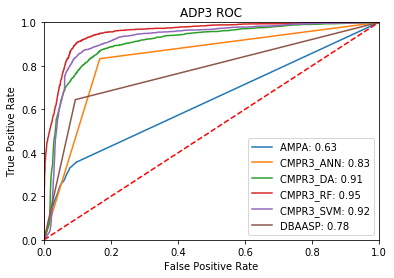

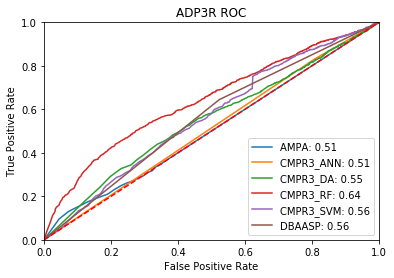

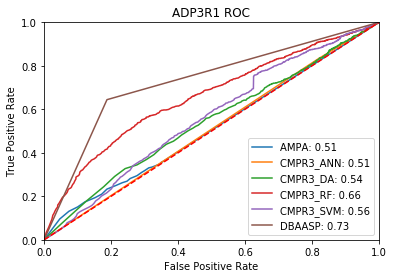

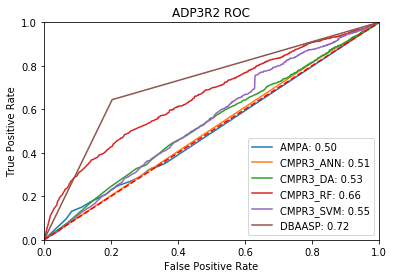

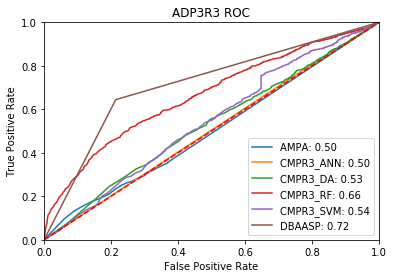

In [9]:
for r in REVERSE:
    plot_roc('ADP3', 'A', r)

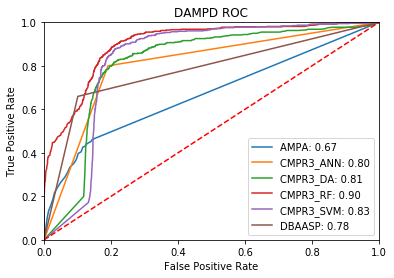

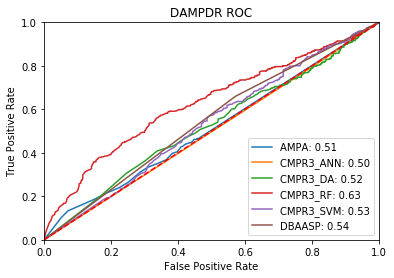

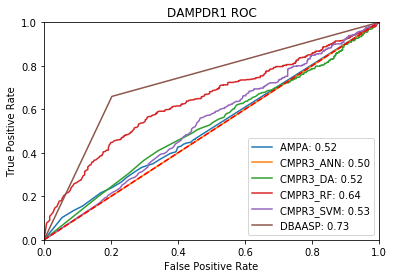

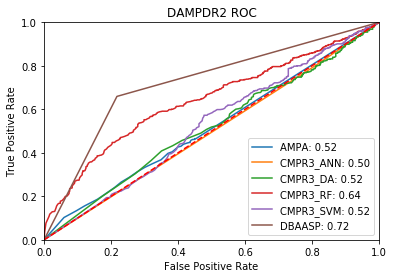

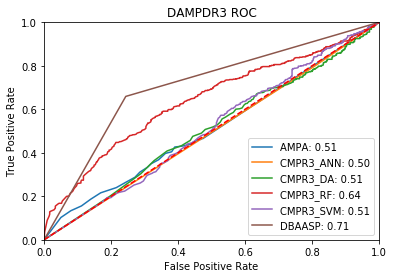

In [10]:
for r in REVERSE:
    plot_roc('DAMPD', 'D', r)

## Feature Dependence Analysis

### Length vs Prediction Probability

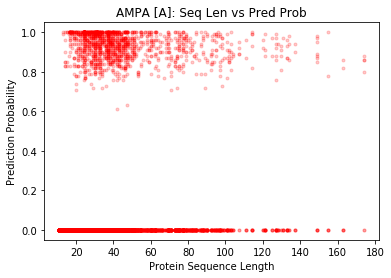

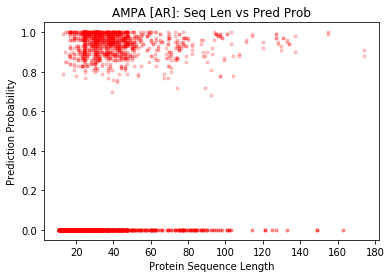

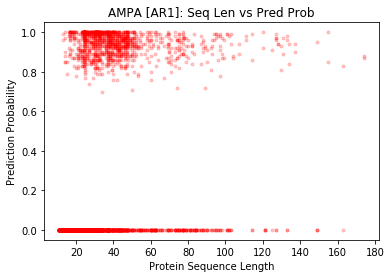

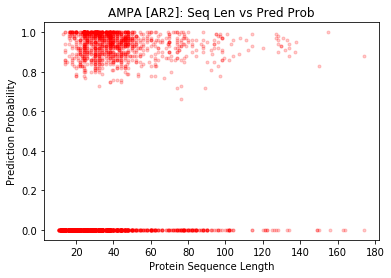

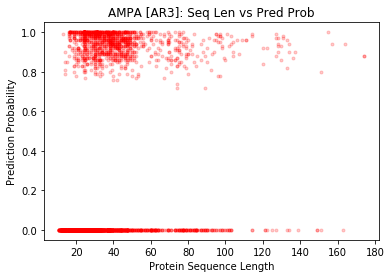

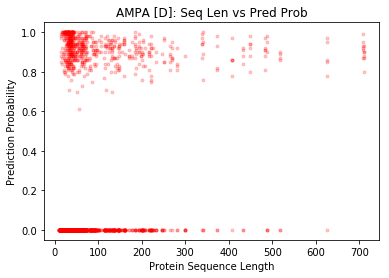

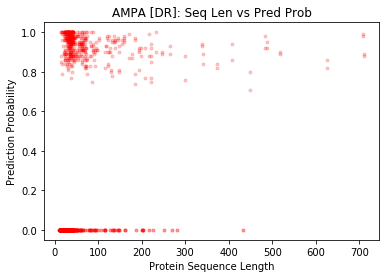

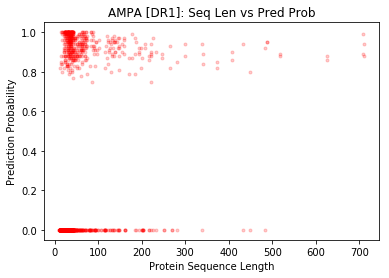

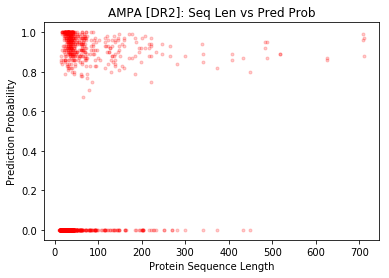

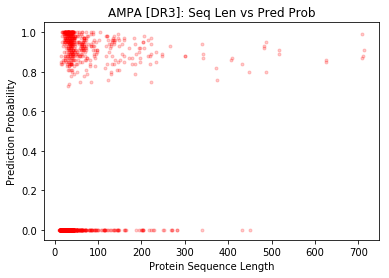

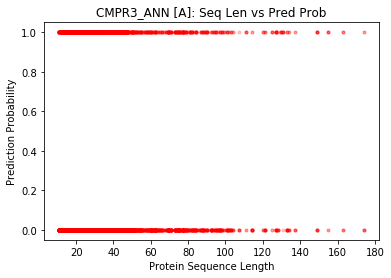

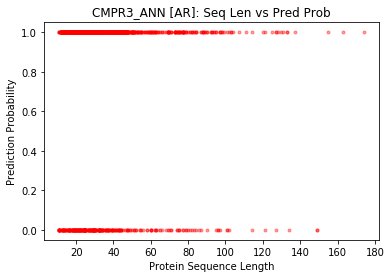

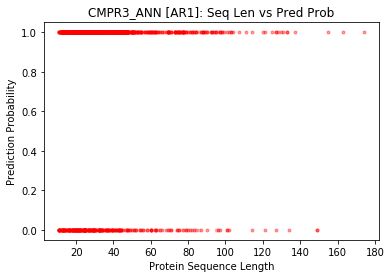

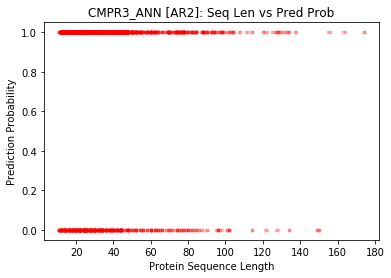

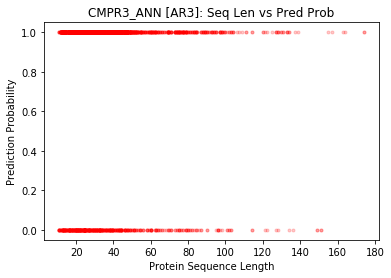

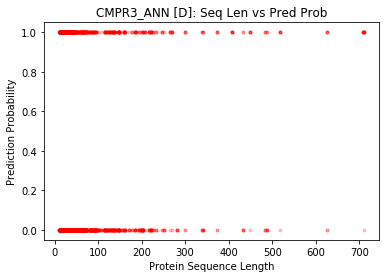

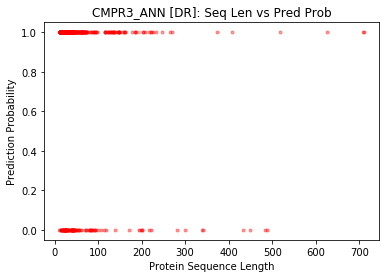

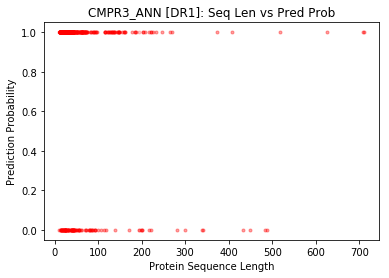

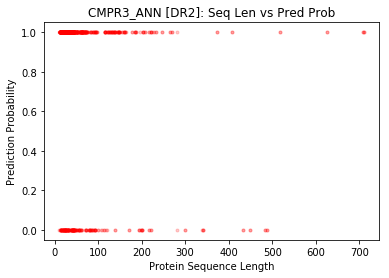

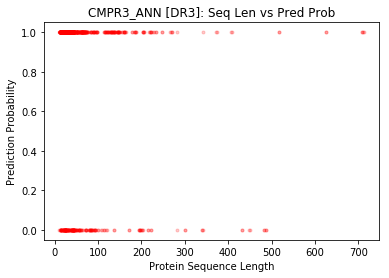

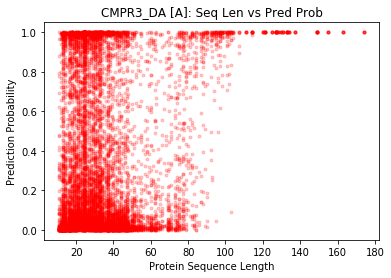

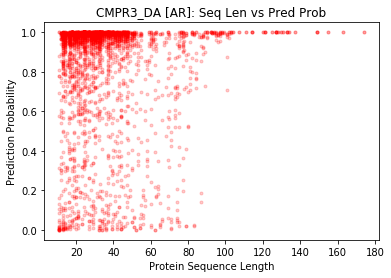

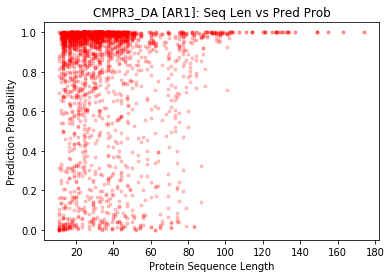

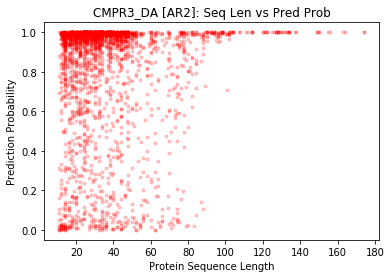

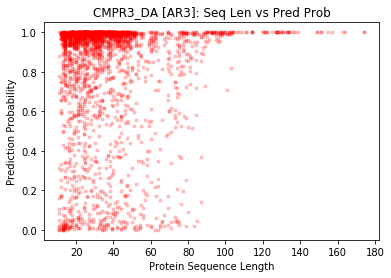

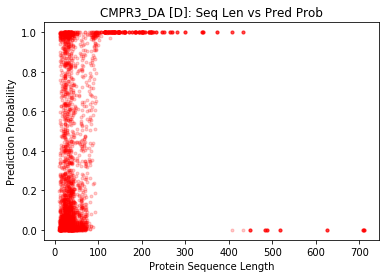

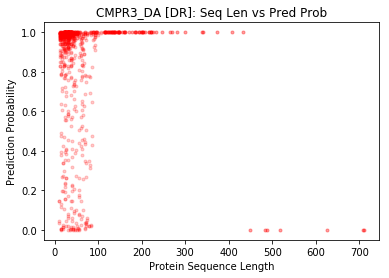

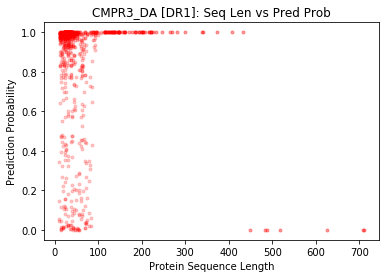

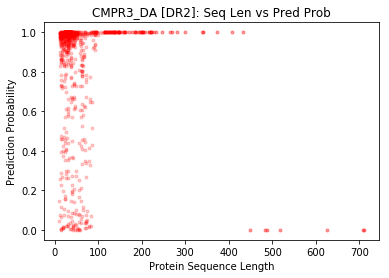

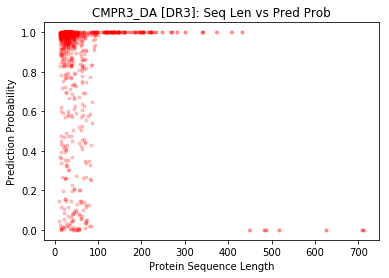

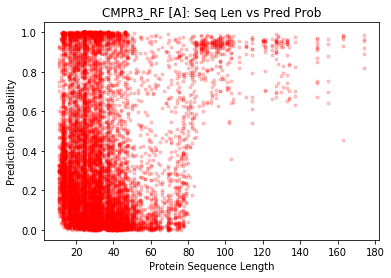

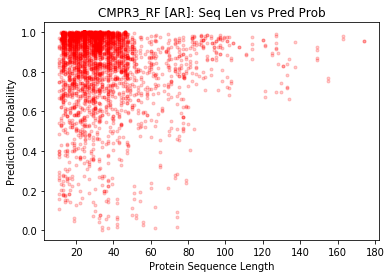

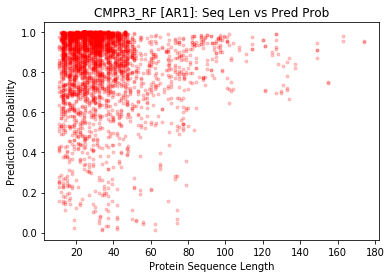

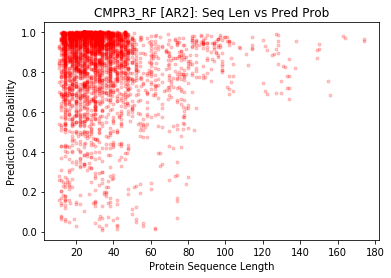

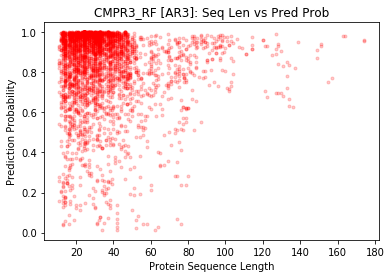

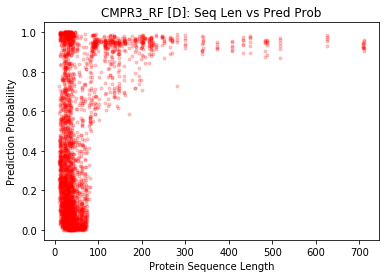

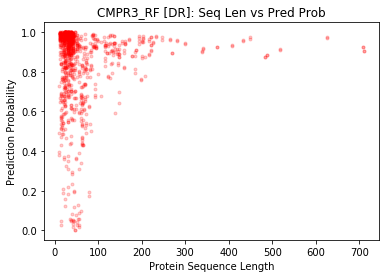

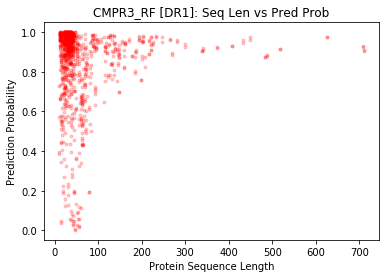

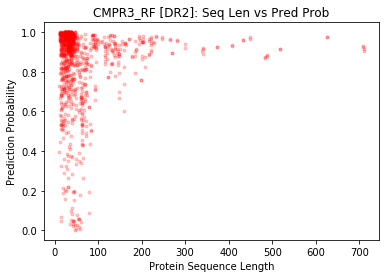

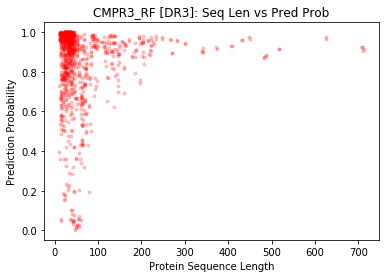

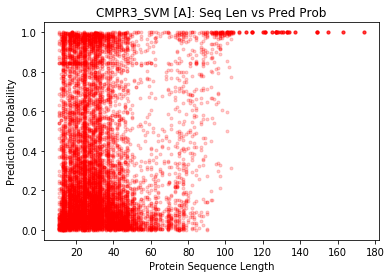

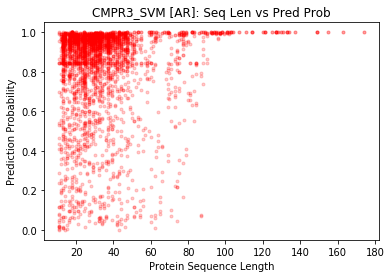

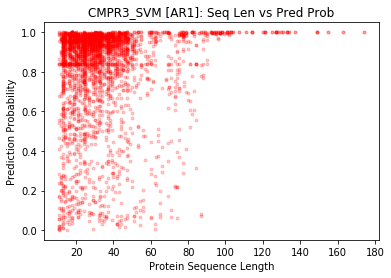

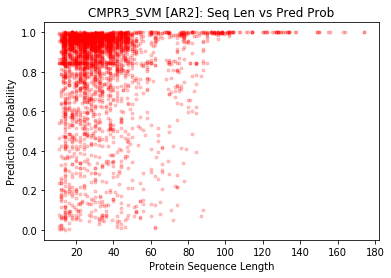

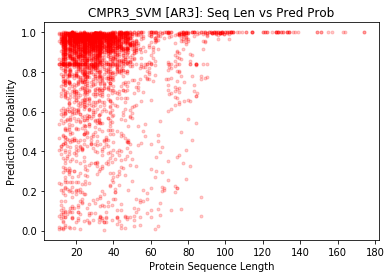

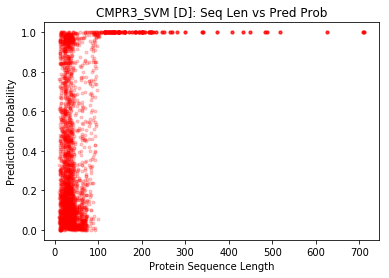

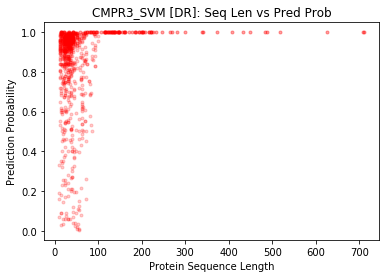

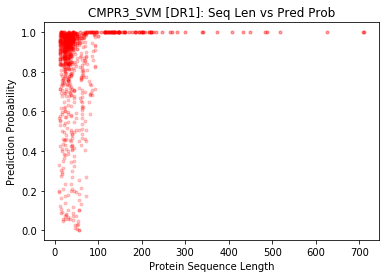

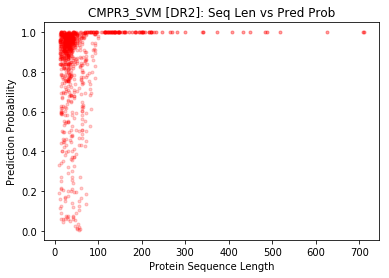

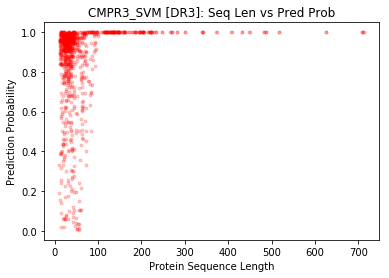

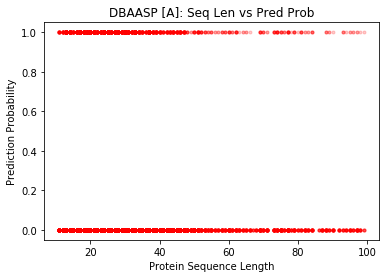

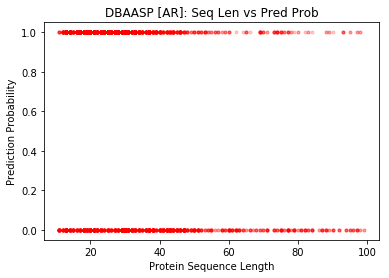

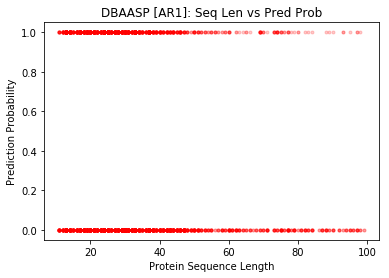

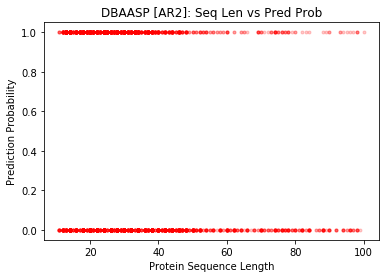

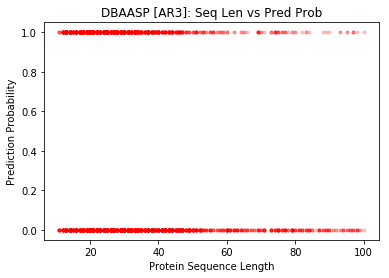

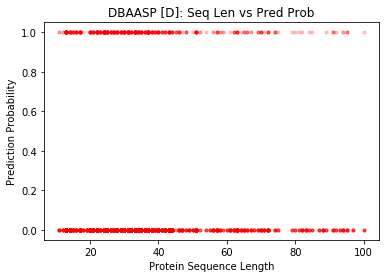

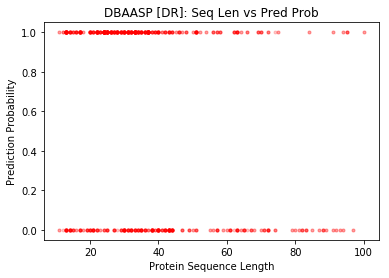

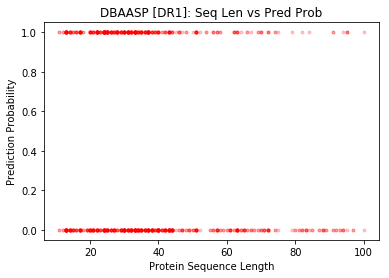

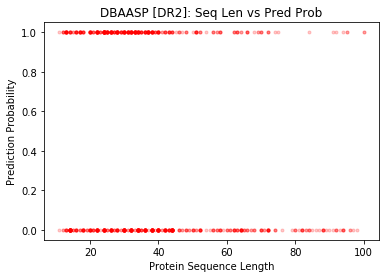

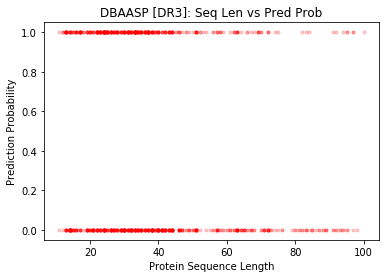

In [11]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            plt.title(s + ' ['+d+r+']' + ': Seq Len vs Pred Prob')
            plt.plot(data[s][d][r]['PepSeq'].apply(len), data[s][d][r]['PredScore'], 'r.', alpha=0.2)
            plt.xlabel('Protein Sequence Length')
            plt.ylabel('Prediction Probability')
            plt.show()

### Number of Unique Protein Count vs Prediction Probability

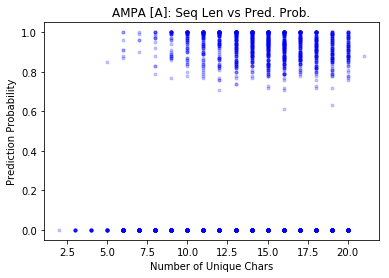

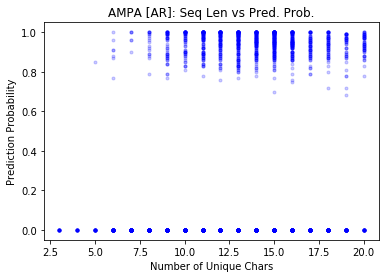

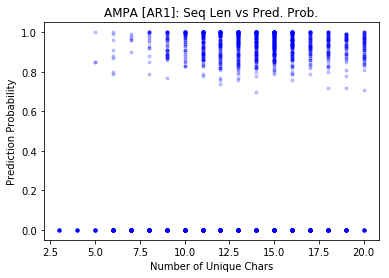

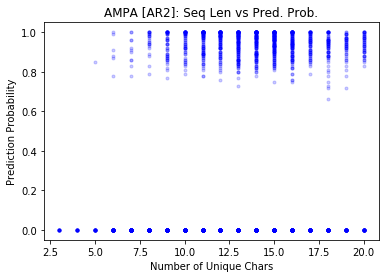

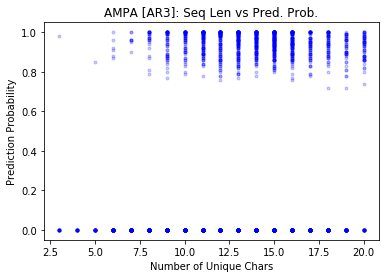

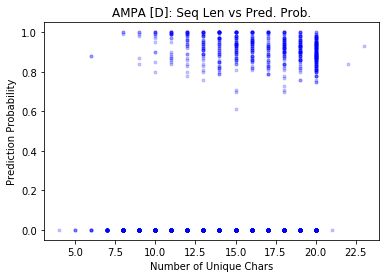

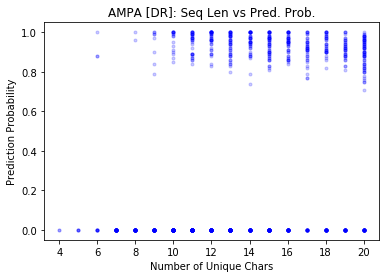

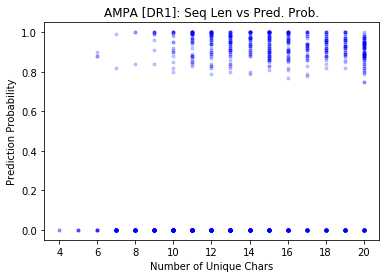

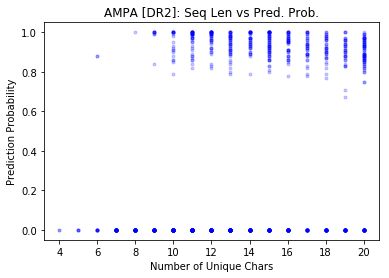

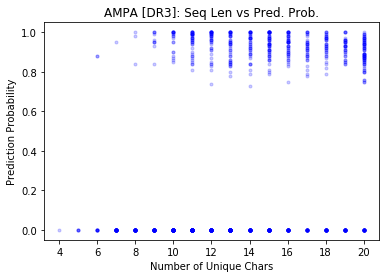

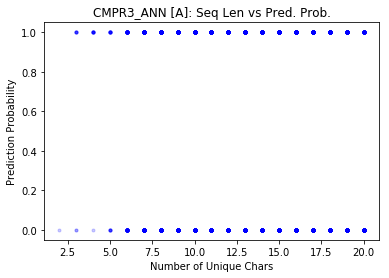

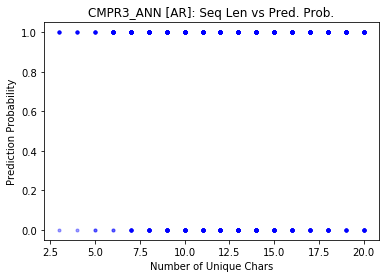

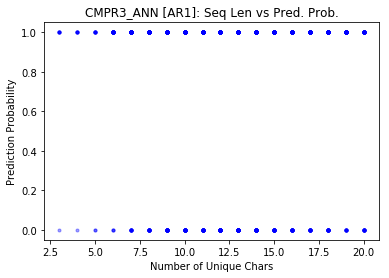

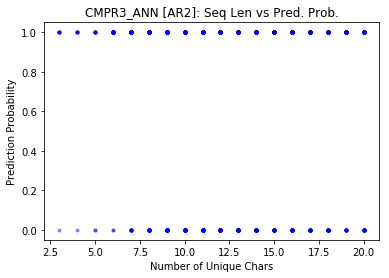

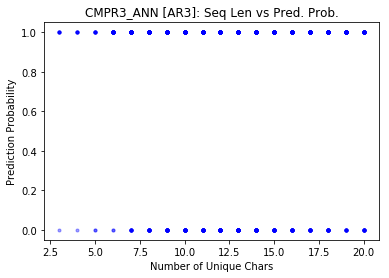

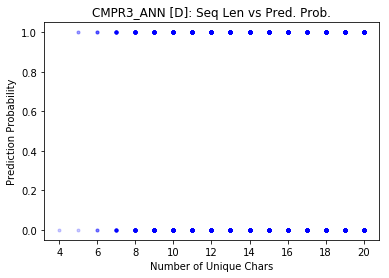

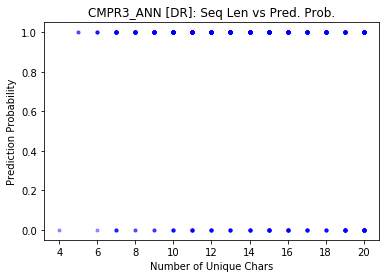

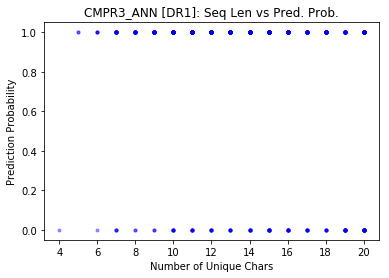

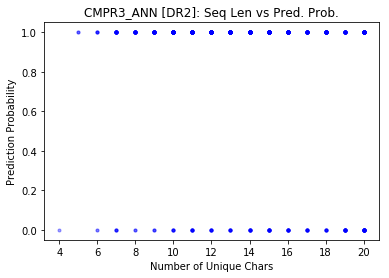

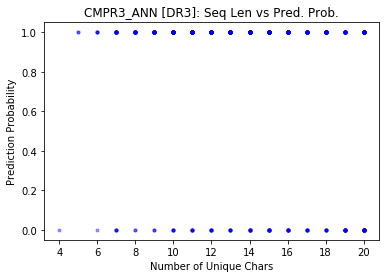

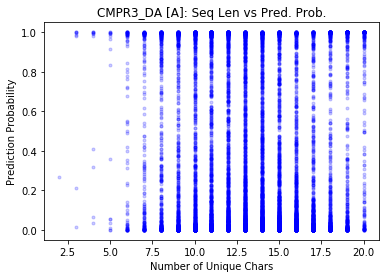

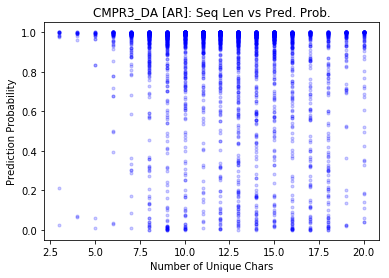

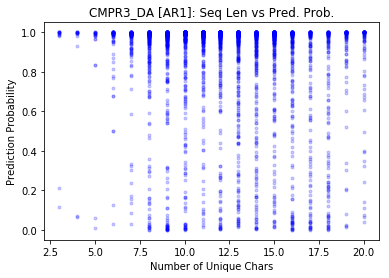

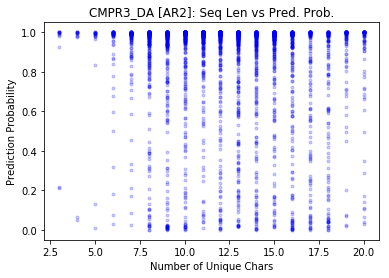

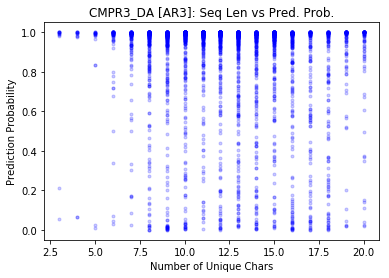

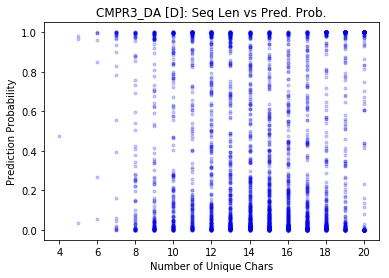

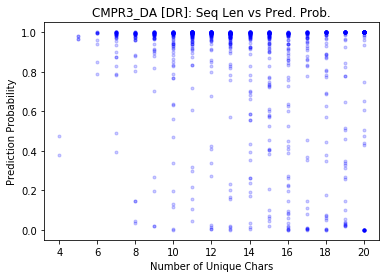

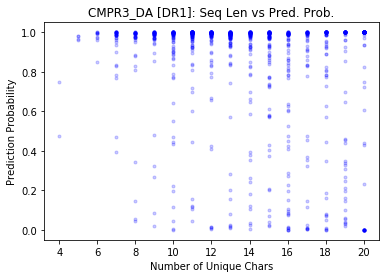

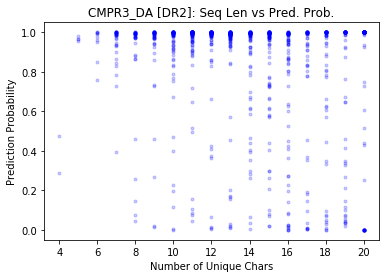

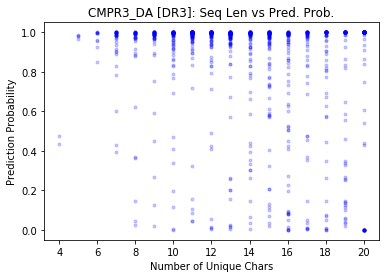

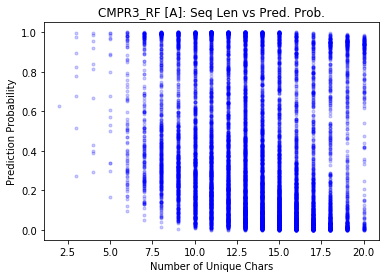

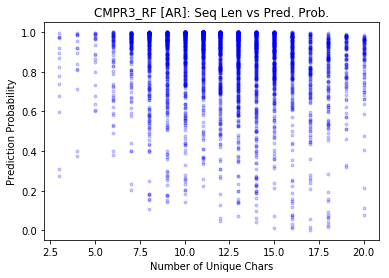

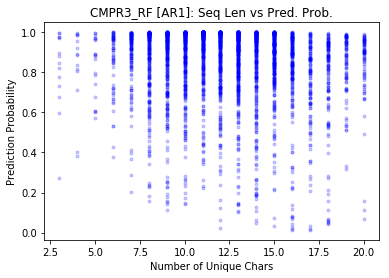

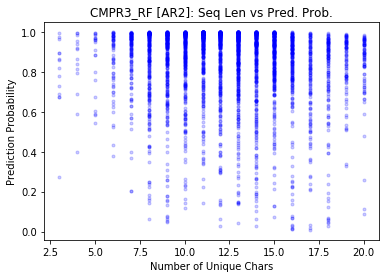

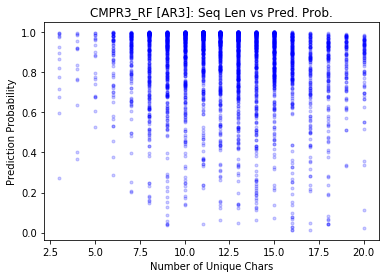

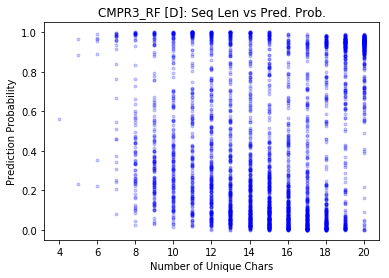

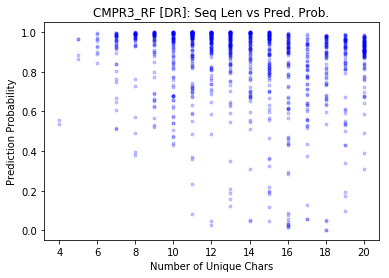

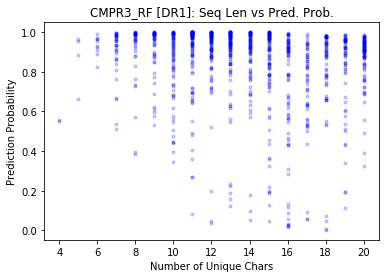

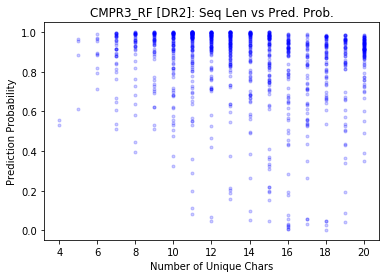

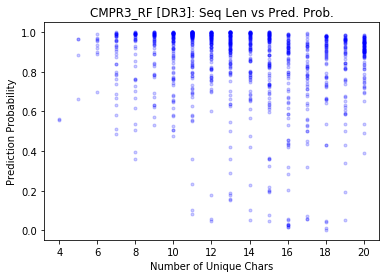

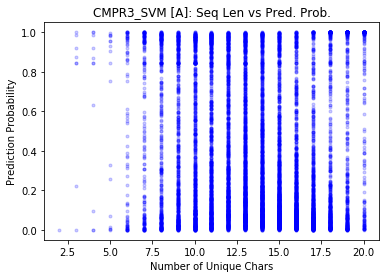

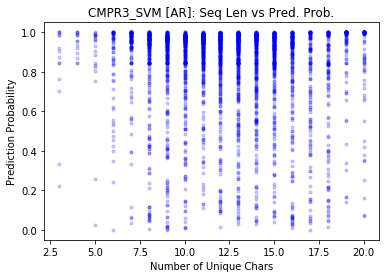

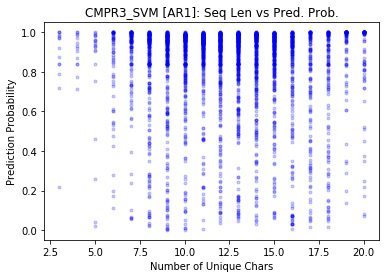

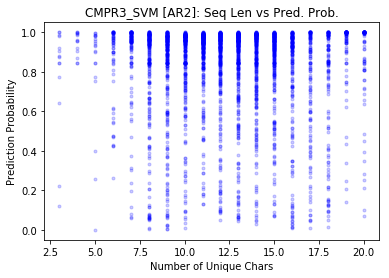

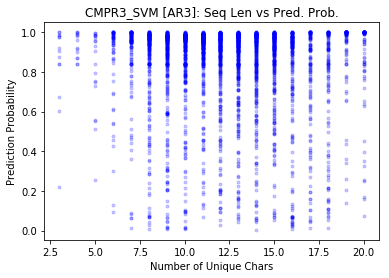

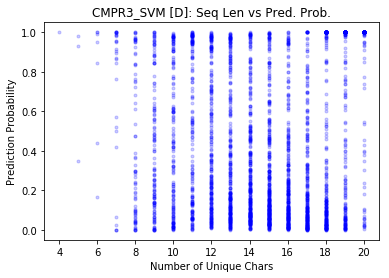

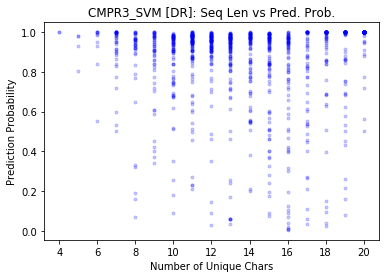

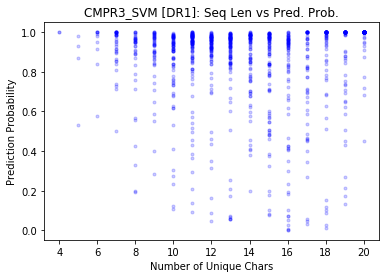

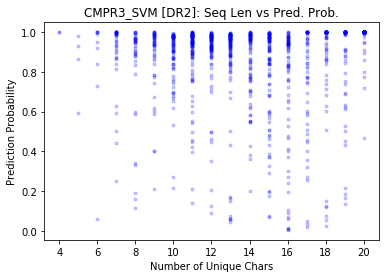

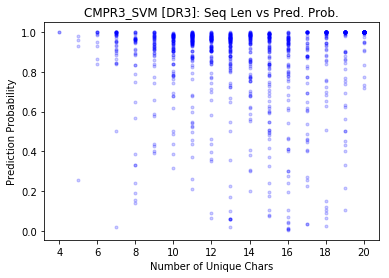

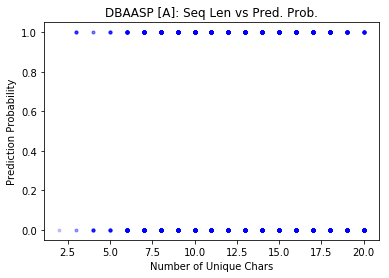

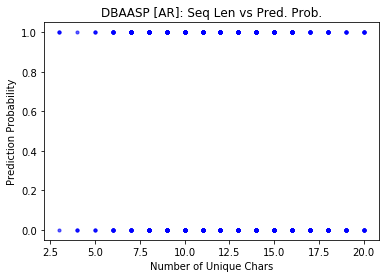

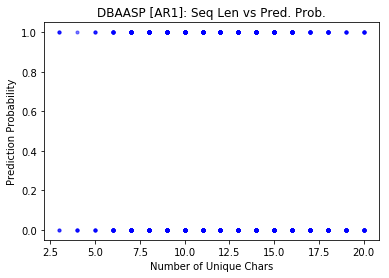

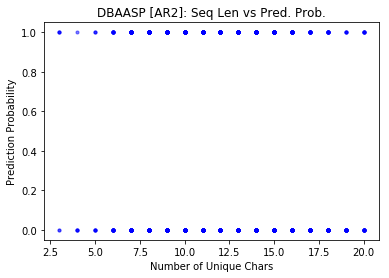

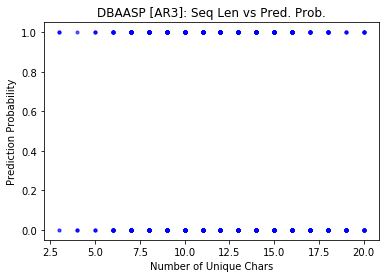

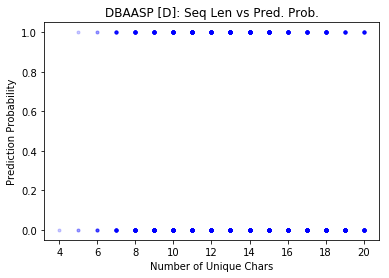

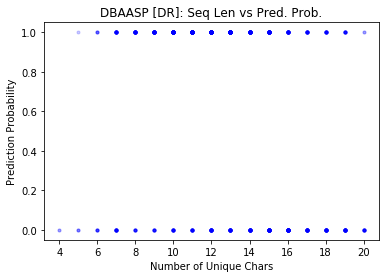

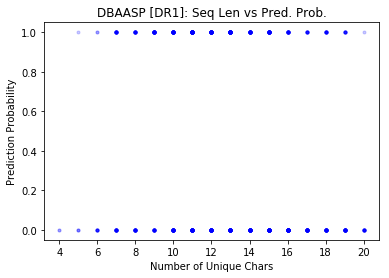

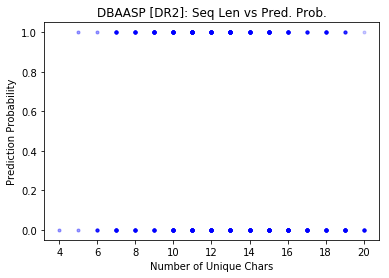

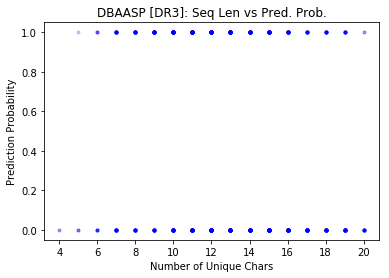

The node with client ID 024ea8df4bba0f420031463997a7f5fe19e3a110 has been marked dead because the monitor has missed too many heartbeats from it.


In [12]:
for s in SERVERS:
    for d in DATASET:
        for r in REVERSE:
            plt.title(s + ' ['+d+r+']' + ': Seq Len vs Pred. Prob.')
            plt.plot(data[s][d][r]['PepSeq'].apply(lambda x: len(set(x))), data[s][d][r]['PredScore'], 'b.', alpha=0.2)
            plt.xlabel('Number of Unique Chars')
            plt.ylabel('Prediction Probability')
            plt.show()